# 📓 Brick E1 – Cloud Object Storage & Cloud-Native Formats

**Part of Modern GIS Bricks**  
*Learn to upload local GIS files, convert them to cloud-native formats, and write them back to object storage.*

**Goals**  
1. Upload GeoTIFF & Shapefile → S3/MinIO  
2. Convert:
   - GeoTIFF → COG
   - Shapefile → GeoParquet  
3. Write outputs back to cloud storage  

## Lesson 1: Configuring your S3 environment

We’ll read and write from S3.  You need to set your AWS credentials and bucket name before we can proceed.

**Exercise:**  
Fill in your AWS keys _or_ ensure they’re set in your environment.  

In [151]:
# Cell 1: Setup & Credentials
import os
from obstore.store import S3Store

# ── Exercise: provide your AWS credentials (or ensure env-vars are set) ──────
# TODO: remove hard-coded values and rely on Gitpod env-vars instead
os.environ["AWS_ACCESS_KEY_ID"]     = "YOUR_KEY_ID"
os.environ["AWS_SECRET_ACCESS_KEY"] = "YOUR_ACCESS_KEY"
os.environ["AWS_DEFAULT_REGION"]    = "us-east-1"            # Experiment: try another region

# Exercise: set your bucket name
bucket = "modern-gis"          # TODO

# Instantiate the store
store = S3Store(bucket=bucket)
print("✅ Connected to S3 bucket:", bucket)



✅ Connected to S3 bucket: modern-gis


## 2. Upload Local Files to S3

We’ll push these local files into your S3 bucket:

- `data/esa_world_cover.tif`  
- `data/parks.gpkg`

Destination: `my-s3-bucket/e1-input/`

In [ ]:
# 2️⃣ Cell: Upload local sample files to S3 via obstore
local_raster  = "data/esa_world_cover.tif"
local_geopackage = "data/parks.gpkg"
bucket        = "modern-gis"
prefix = "e1-input"

In [3]:
store.put("e1-input/esa_world_cover.tif", open(local_raster, "rb"))
print(f"Uploaded {local_raster}")

Uploaded data/esa_world_cover.tif


In [43]:
store.put("e1-input/parks.gpkg", open(local_geopackage, "rb"))
print(f"Uploaded {local_geopackage}")

Uploaded data/parks.gpkg


## 3. COG Best Practices

A Cloud-Optimized GeoTIFF (COG) is a valid GeoTIFF laid out for fast HTTP range requests. Key recommendations:

- **Internal tiling**: 256×256 or 512×512 blocks  
- **Overviews**: generate downsampled levels (smallest ≲256 px)  
- **Compression**: DEFLATE or LZW with PREDICTOR=2 (ints) or 3 (floats)  
- **NoData**: explicitly set (e.g. `NaN` for floats, max-neg for ints)  
- **Projection**: use a known EPSG code, WKT2 format  
- **Web-optimized** (optional): align tiles & overviews to Web Mercator 256 px grid 


## Part 3.1: Fetching a Remote GeoTIFF into VSIMEM

We’ll pull down the GeoTIFF bytes from S3 and wrap them in a Rasterio `MemoryFile` (GDAL’s `/vsimem/`).

**Exercise:**
1. Fill in `in_key` (the path to your source TIFF in the bucket).  
2. Wrap the bytes in `io.BytesIO` so `MemoryFile` will accept them.  
3. Print out `src_ds.profile` to inspect the source metadata.

In [102]:
# Cell 2: Read GeoTIFF as bytes → VSIMEM
import io
from rasterio.io import MemoryFile

# Exercise: path to your input file in S3
prefix   = "e1-input"                             # TODO if you changed it
in_key   = f"{prefix}/esa_world_cover.tif"        # TODO

# 1️⃣ Fetch raw bytes from S3
resp        = store.get(in_key)
tiff_bytes  = resp.bytes()      # raw bytes pulled via obstore

# 2️⃣ Wrap in BytesIO for MemoryFile
data_buf = io.BytesIO(tiff_bytes)

# 3️⃣ Open in VSIMEM and inspect
with MemoryFile(file_or_bytes=data_buf) as src_mem:
    with src_mem.open() as src_ds:
        print("Source profile:", src_ds.profile)  # Exercise: inspect this

Source profile: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 36000, 'height': 36000, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.333333333333333e-05, 0.0, -123.0,
       0.0, -8.333333333333333e-05, 48.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


## Part 3.2: Tuning the Output Profile

A Cloud-Optimized GeoTIFF (COG) requires:

* internal tiling (`tiled=True`, with block size settings)
* an efficient compression algorithm and predictor
* overviews (optionally added; here, handled automatically by `rio-cogeo` when needed)

In this exercise, you’ll fetch a standard GeoTIFF from S3, modify its tiling and compression settings, convert it into a Cloud-Optimized GeoTIFF entirely in memory using `rio-cogeo`, and upload the optimized result back to S3—**without writing any intermediate files to disk.**

**Key Concepts Covered:**

1. **Remote I/O** via `obstore.get()`
2. **In-memory file operations** using `rasterio.io.MemoryFile`
3. **COG tuning** through the GDAL-compatible profile
4. **Preset profiles** from `rio-cogeo` and customization with `cog_translate`
5. **Zero-disk COG conversion** (optionally switchable to disk-based temp files)

> **Exercise:**
>
> * Swap hardcoded paths with variables or environment variables.
> * Set `in_key` and `out_key` to match your S3 layout.
> * Experiment with different `blockxsize`, `compress`, and `predictor` settings to compare output size and read performance.

In [106]:
from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles
from rasterio.io import MemoryFile
import obstore as obs
import io

# 1️⃣ Configure store & keys
# TODO: set your S3 keys
in_key   = "e1-input/esa_world_cover.tif"
out_key  = "e1-output/esa_world_cover_cog.tif"

# ── 2️⃣ Fetch raw GeoTIFF bytes from S3 ──────────────────────────────────────
resp       = store.get(in_key)
tiff_bytes = resp.bytes()           # raw TIFF data

# ── 3️⃣ Wrap in BytesIO so MemoryFile accepts it ─────────────────────────────
data_buf = io.BytesIO(tiff_bytes)

# ── 4️⃣ Open source in VSIMEM & build destination profile ───────────────────
with MemoryFile(file_or_bytes=data_buf) as src_mem:
    with src_mem.open() as src_ds:
        # Copy source metadata & tweak for COG
        dst_profile = src_ds.profile.copy()
        dst_profile.update({
            "driver":     "GTiff",            # must remain GTiff
            "tiled":      True,               # required for internal tiles
            "blockxsize": 512,                # TODO: try 256, 1024
            "blockysize": 512,                # TODO
            "compress":   "DEFLATE",          # TODO: try "LZW" or "ZSTD"
            "predictor":  2,                  # 2 for ints, 3 for floats
        })

        # ── 5️⃣ Pick & tweak rio-cogeo profile ────────────────────────────────
        profile = cog_profiles.get("deflate")   # TODO: try "lzw" or "zstd"
        profile["blockxsize"] = dst_profile["blockxsize"]
        profile["blockysize"] = dst_profile["blockysize"]

        # ── 6️⃣ Create COG entirely in memory ────────────────────────────────
        with MemoryFile() as dst_mem:
            with dst_mem.open(**dst_profile) as dst_ds:
                cog_translate(
                    src_ds.name,
                    dst_ds.name,
                    profile,
                    nodata=src_ds.nodata,    # reuse source NoData
                    in_memory=True           # TODO: try False to use temp files
                )

            # ── 7️⃣ Upload the in-memory COG back to S3 ───────────────────────
            dst_mem.seek(0)
            store.put(out_key, dst_mem.read())

print(f"✅ COG created & uploaded to s3://{bucket}/{out_key}")

Reading input: /vsimem/7f4998c6-f4f5-4bd6-9507-4cc4725a06ac/7f4998c6-f4f5-4bd6-9507-4cc4725a06ac.tif

Adding overviews...
Updating dataset tags...
Writing output to: /vsimem/85e9f936-c616-4a41-bf13-b03bf36aa8ae/85e9f936-c616-4a41-bf13-b03bf36aa8ae.tif


✅ COG created & uploaded to s3://modern-gis/e1-output/esa_world_cover_cog.tif


# 4 GeoParquet Best Practices

When writing GeoParquet:

- **Version**: 1.1 with the `bbox` covering struct  
- **Compression**: ZSTD  
- **Row-group size**: 100 000–200 000 rows  
- **Spatial partitions**: geohash, S2/H3, or admin boundaries  
- **Hive partitions** (optional): e.g. `country_iso=*` to prune files server-side  

## Part 4.1: Loading a GeoPackage into GeoPandas

We’ll load your `/parks.gpkg` into memory via Fiona’s MemoryFile.  This avoids local files on disk.

**Exercise:**  
- Fill in the `gpkg_key` (path within your bucket).  
- Then run and inspect `gdf.head()`.  

In [125]:
# Cell 2: Load parks.gpkg into GeoDataFrame
import io
import geopandas as gpd
from fiona.io import MemoryFile

# Exercise: point to where your parks.gpkg lives
prefix    = "e1-input"                 # TODO: adjust if needed
gpkg_key  = f"{prefix}/parks.gpkg"     # TODO

# 1️⃣ Fetch the file as raw bytes
resp = store.get(gpkg_key)
raw_bytes = resp.bytes()
buf = io.BytesIO(raw_bytes)

# 2️⃣ Load with Fiona’s MemoryFile
with MemoryFile(file_or_bytes=buf) as memf:
    with memf.open() as src:
        gdf = gpd.GeoDataFrame.from_features(src, crs=src.crs)

# Inspect
gdf.head()

,geometry,NAME,PMA_NAME,ADDRESS,PIN,SUBPARCEL,PMA,OWNER,LEASE,MAINT,USE_,ACQ_DATE,NAMEFLAG,REVIEW_DAT,AMWOID,SDQL,SE_ANNO_CA,GIS_CRT_DT,GIS_EDT_DT,GlobalID
0,"MULTIPOLYGON (((1258961.57 200968.719, 1258966...",None,None,None,2489200285,16822,4463,SPU,N,SPU,None,1899-12-30,0,2011-03-09,PROPERTY-MYRES,QL-D3,None,2025-05-07,2025-05-07,dc828a5f-e037-4a5f-a7bf-1a67af22b823
1,"MULTIPOLYGON (((1283628.75 199080.188, 1283678...",OTHELLO PARK,Othello Park,None,0717000010,182,403,DPR,N,DPR,PG,2099-01-01,9,2012-07-03,PROPERTY-OTHPG,QL-D1,None,2025-05-07,2025-05-07,54bd2a67-e162-41d2-86f5-9babddb00434
2,"MULTIPOLYGON (((1264225.712 210982.422, 126427...",WEST DUWAMISH GREENBELT,West Duwamish Greenbelt,None,7547300385,16122,282,DPR,N,DPR,GB,2001-10-19,9,2002-06-18,PROPERTY-WDUWANDR,QL-D1,None,2025-05-07,2025-05-07,5acc87aa-2c3f-46b8-b912-659f8a765595
3,"MULTIPOLYGON (((1273911.016 219029.597, 127390...",EAST DUWAMISH GREENBELT,East Duwamish GS: I-90,None,3850900395,1141,283,DPR,N,DPR,GB,1994-12-19,9,2004-03-31,PROPERTY-EDUWI,QL-D1,None,2025-05-07,2025-05-07,96c94a6e-c2fd-45e4-a0a1-23ff3d4515d5
4,"MULTIPOLYGON (((1270822.585 230143.995, 127082...",CASCADE PLAYGROUND,Cascade Playground,333 PONTIUS AVE N,2467400335,9853,350,DPR,N,DPR,PK,1997-01-10,9,1998-04-22,PROPERTY-CASPG,QL-D1,None,2025-05-07,2025-05-07,7052b63b-4fbf-48e5-a08b-541ea10f6d68


## Part 4.2: Ensuring the right CRS

Spatial indexing & Hilbert codes require **longitude/latitude** (EPSG:4326).  We’ll reproject if needed.

**Exercise:**  
- Verify `gdf.crs`  
- Fill in the `if` so it reprojects to EPSG:4326.  
- Try plotting `gdf.geometry.boundary` to see your data.


In [126]:
# Cell 3: Reproject to lon/lat if necessary

# TODO: ensure gdf ends up in EPSG:4326
if gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(epsg=4326)

print("Reprojected CRS:", gdf.crs)

Reprojected CRS: EPSG:4326


## Part 4.3: Sampling & Quadtree construction

Rather than simple grids, we’ll build a **quadtree** over a random sample of your data’s centroids.

**Exercise:**  
- Adjust `SAMPLE_SIZE` to sample more or fewer points.  
- Adjust `MAX_PTS_PER_CELL` to control leaf subdivision.  
- Read the code in `quadtree_partition` and add a comment explaining how it works.

In [127]:
# Cell 4: Build quadtree partitions
import random

# 1️⃣ Compute representative points
pts = list(gdf.geometry.representative_point())

# 2️⃣ Sample them
SAMPLE_SIZE         = 5000     # TODO: experiment with 1000, 10000
MAX_PTS_PER_CELL    = 200      # TODO: experiment with 50, 500

if len(pts) > SAMPLE_SIZE:
    sample_pts = random.sample(pts, SAMPLE_SIZE)
else:
    sample_pts = pts

# 3️⃣ Quadtree function (read & annotate)
def quadtree_partition(samples, bounds, max_pts):
    cells = []
    def subdivide(bbox, pts):
        # If below threshold, stop splitting
        if len(pts) <= max_pts:
            cells.append(bbox)
            return
        minx, miny, maxx, maxy = bbox
        midx, midy = (minx+maxx)/2, (miny+maxy)/2
        # Define 4 quadrants
        quadrants = [
            (minx, miny, midx, midy),
            (midx, miny, maxx, midy),
            (minx, midy, midx, maxy),
            (midx, midy, maxx, maxy),
        ]
        # Subdivide each quadrant that has sample points
        for q in quadrants:
            q_pts = [p for p in pts if q[0] <= p.x < q[2] and q[1] <= p.y < q[3]]
            if q_pts:
                subdivide(q, q_pts)
    subdivide(bounds, sample_pts)
    return cells

# 4️⃣ Run it
bounds = tuple(gdf.total_bounds)   # (minx, miny, maxx, maxy)
cells  = quadtree_partition(sample_pts, bounds, MAX_PTS_PER_CELL)

print(f"Generated {len(cells)} quadtree cells")

Generated 45 quadtree cells


## Part 4.4 Compute spatial key & sort your GeoDataFrame  
Generate a Hilbert/geohash code and sort by it:

In [135]:
# pick one point per polygon and encode
gdf["hcode"] = (
  gdf.geometry
     .representative_point()
     .apply(lambda pt: gh.encode(pt.x, pt.y, precision))
)
# sort by that key
gdf_sorted = gdf.sort_values("hcode")

## Part 4.5: Writing a Single GeoParquet to S3

In this step, you’ll convert a GeoDataFrame into a single GeoParquet file and upload it directly to S3—all in memory, with no disk writes. The output uses efficient compression (`ZSTD`), includes bounding box metadata, and sets a custom `row_group_size` for optimized reads in analytical workflows.

**Key Concepts Covered:**

* In-memory file creation with `io.BytesIO`
* GeoParquet writing using PyArrow
* Efficient S3 upload with `obstore.put()`
* Configurable geometry encoding and row group tuning for performance


In [ ]:
# ── Part 1: Write a single GeoParquet file to S3 ────────────────────────────────
import os
import geopandas as gpd
import io

# 1️⃣ Build the GeoParquet into a bytes buffer
buf = io.BytesIO()
gdf_sorted.to_parquet(
    buf,
    index=False,
    compression="ZSTD",
    schema_version="1.1.0",
    geometry_encoding="WKB",     # or "geoarrow" if you want the Arrow extension type
    write_covering_bbox=True,
    engine="pyarrow",
    row_group_size=150_000
)
parquet_bytes = buf.getvalue()

pq_key = "e1-output/parks.parquet"
resp = obs.put(store, pq_key, parquet_bytes)
print(resp)
print("✅ GeoParquet written!")

{'e_tag': '"57b0f6d8d25c4132a37280bac2886115"', 'version': None}
✅ GeoParquet written!


## Part 4.6: Writing Partitioned GeoParquet Files to S3

This step splits a GeoDataFrame by a quadtree-based `partition` column and writes each group as a separate GeoParquet file to S3. Each partition is serialized in-memory using `BytesIO`, compressed with `ZSTD`, and saved with optimized row groups for scalable reads.

**Key Concepts Covered:**

* Spatial partitioning using quadtree bins
* Memory-based Parquet export per partition
* Organized S3 layout (`cell=ID/parks.parquet`) for easy querying and retrieval
ioned

In [ ]:
import os
import io
import geopandas as gpd
import obstore as obs
from obstore.store import S3Store

# assume gdf_sorted already has a “partition” column from your quadtree step
base_prefix = "e1-output/parks_quadtree"

# ── Loop over each partition and write via GeoPandas + BytesIO ────────────────
for pid, grp in gdf_sorted.groupby("partition"):
    # 1️⃣ Serialize this subset as GeoParquet into memory
    buf = io.BytesIO()
    grp.to_parquet(
        buf,
        index=False,
        compression="ZSTD",
        schema_version="1.1.0",
        geometry_encoding="WKB",
        write_covering_bbox=True,
        engine="pyarrow",
        row_group_size=150_000
    )
    parquet_bytes = buf.getvalue()
    buf.close()

    # 2️⃣ Upload the in-memory Parquet to S3
    key = f"{base_prefix}/cell={int(pid)}/parks.parquet"
    resp = obs.put(store, key, parquet_bytes)
    print(f"✅ Partition {pid} → s3://{bucket}/{key}")


✅ Partition 0 → s3://modern-gis/e1-output/parks_quadtree/cell=0/parks.parquet
✅ Partition 1 → s3://modern-gis/e1-output/parks_quadtree/cell=1/parks.parquet
✅ Partition 2 → s3://modern-gis/e1-output/parks_quadtree/cell=2/parks.parquet
✅ Partition 3 → s3://modern-gis/e1-output/parks_quadtree/cell=3/parks.parquet
✅ Partition 4 → s3://modern-gis/e1-output/parks_quadtree/cell=4/parks.parquet
✅ Partition 5 → s3://modern-gis/e1-output/parks_quadtree/cell=5/parks.parquet
✅ Partition 6 → s3://modern-gis/e1-output/parks_quadtree/cell=6/parks.parquet
✅ Partition 7 → s3://modern-gis/e1-output/parks_quadtree/cell=7/parks.parquet
✅ Partition 8 → s3://modern-gis/e1-output/parks_quadtree/cell=8/parks.parquet
✅ Partition 9 → s3://modern-gis/e1-output/parks_quadtree/cell=9/parks.parquet
✅ Partition 10 → s3://modern-gis/e1-output/parks_quadtree/cell=10/parks.parquet
✅ Partition 11 → s3://modern-gis/e1-output/parks_quadtree/cell=11/parks.parquet
✅ Partition 12 → s3://modern-gis/e1-output/parks_quadtree/ce

## Part 4.7: Visualizing your partitions

Finally, let’s see how your quadtree cells align with the data.  We’ll plot the representative points and over-draw all cell rectangles.

_No code to fill in here—just run and inspect!_

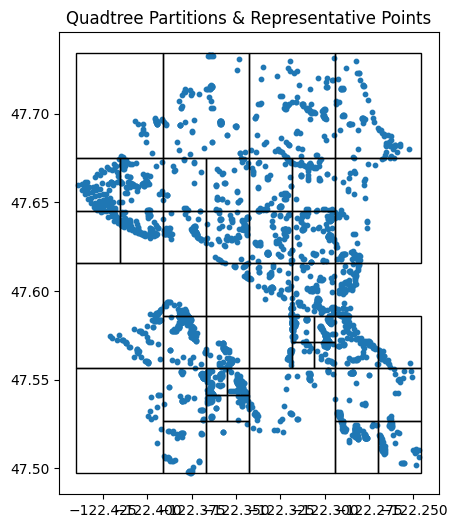

In [90]:
# Cell 6: Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

pts = gdf.geometry.representative_point()

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter([p.x for p in pts], [p.y for p in pts], s=10)

for (minx, miny, maxx, maxy) in cells:
    ax.add_patch(Rectangle((minx,miny), maxx-minx, maxy-miny, fill=False))

ax.set_aspect("equal")
ax.set_title("Quadtree Partitions & Representative Points")
plt.show()

## 5. (Optional) Preview Files from S3

List and inspect the generated COG and GeoParquet.

In [148]:
# Cell 1: Read the newly created remote datasets directly

import os
import geopandas as gpd
import rasterio

# 1️⃣ Read GeoParquet from S3 (via fsspec/S3)
pq_s3_path = f"s3://{bucket}/e1-output/parks.parquet"
gdf = gpd.read_parquet(
    pq_s3_path,
    storage_options={"anon": False}
)
print("✅ GeoParquet rows:", len(gdf))

# 2️⃣ Open the COG via GDAL’s VSIS3 driver
cog_s3_path = f"/vsis3/{bucket}/e1-input/e1-output/esa_world_cover_cog.tif"
with rasterio.open(cog_s3_path) as src:
    print("✅ COG bounds:", src.bounds)
    print("✅ COG overview levels:", src.overviews(1))

✅ GeoParquet rows: 2826
✅ COG bounds: BoundingBox(left=-123.0, bottom=45.0, right=-120.0, top=48.0)
✅ COG overview levels: []


## 6. Summary & Next Steps

- ✅ Uploaded raw files for testing to S3 and local GitHub submission  
- ✅ Converted to COG & GeoParquet using best practices  
- Files stored under `my-minio-bucket/e1-output/`  

**Next:** Brick E2 – Iceberg partitioning & time-travel

In [ ]:
# Cell 2: Download the parquet locally & save minimal COG metadata for tests

import os
import json
import obstore as obs
from obstore.store import S3Store
from rio_cogeo.cogeo import cog_info

# Setup
out_dir = "tests/outputs"
os.makedirs(out_dir, exist_ok=True)

cog_key = "e1-input/e1-output/esa_world_cover_cog.tif"
cog_uri = f"/vsis3/{bucket}/{cog_key}"
info    = cog_info(cog_uri)

print(info)

meta = {
    "bounds": list(info["BoundingBox"]),
    "tile_size":   {
        "x": info["profile"]["blockxsize"],
        "y": info["profile"]["blockysize"],
    },
    "compression": info["profile"]["compress"],
    "overviews":   info["overviews"],
}

meta_path = os.path.join(out_dir, "esa_world_cover_cog_meta.json")
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)

print("✅ Wrote COG metadata to", meta_path)

Path='/vsis3/modern-gis/e1-input/e1-output/esa_world_cover_cog.tif' Driver='GTiff' COG=False Compression='DEFLATE' ColorSpace=None COG_errors=['The offset of the main IFD should be < 300. It is 68397092 instead'] COG_warnings=['The file is greater than 512xH or 512xW, it is recommended to include internal overviews'] Profile=Profile(Bands=1, Width=36000, Height=36000, Tiled=True, Dtype='uint8', Interleave='BAND', AlphaBand=False, InternalMask=False, Nodata=0.0, ColorInterp=('gray',), ColorMap=False, Scales=(1.0,), Offsets=(0.0,)) GEO=Geo(CRS='EPSG:4326', BoundingBox=(-123.0, 45.0, -120.0, 48.0), Origin=(-123.0, 48.0), Resolution=(8.333333333333333e-05, -8.333333333333333e-05), MinZoom=7, MaxZoom=14) Tags={'Image Metadata': {'AREA_OR_POINT': 'Area'}, 'Image Structure': {'LAYOUT': 'COG', 'COMPRESSION': 'DEFLATE', 'INTERLEAVE': 'BAND', 'PREDICTOR': '2'}} Band_Metadata={'Band 1': BandMetadata(Description=None, ColorInterp='gray', Offset=0.0, Scale=1.0, Metadata={})} IFD=[IFD(Level=0, Width

KeyError: 'BoundingBox'